In [351]:
import pandas as pd
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)
import matplotlib.pyplot as plt
from mplsoccer import FontManager, VerticalPitch, add_image
from PIL import Image
import numpy as np
import os 
import difflib

In [352]:
pagina = pd.read_html("https://fbref.com/es/equipos/b8fd03ef/2022-2023/all_comps/Estadisticas-de-Manchester-City-Todas-las-competencias")

In [353]:
len(pagina)

67

In [354]:
df_stats = pagina[0]
df_stats.columns = ["_".join(col) if 'Unnamed' not in col[0] else col[1] for col in df_stats.columns.values]
df_stats.columns

Index(['Jugador', 'País', 'Posc', 'Edad', 'PJ', 'Tiempo Jugado_Titular',
       'Tiempo Jugado_Mín', 'Tiempo Jugado_90 s', 'Rendimiento_Gls.',
       'Rendimiento_Ass', 'Rendimiento_G+A', 'Rendimiento_G-TP',
       'Rendimiento_TP', 'Rendimiento_TPint', 'Rendimiento_TA',
       'Rendimiento_TR', 'Expectativa_xG', 'Expectativa_npxG',
       'Expectativa_xAG', 'Expectativa_npxG+xAG', 'Progresión_PrgC',
       'Progresión_PrgP', 'Progresión_PrgR', 'Por 90 Minutos_Gls.',
       'Por 90 Minutos_Ast', 'Por 90 Minutos_G+A', 'Por 90 Minutos_G-TP',
       'Por 90 Minutos_G+A-TP', 'Por 90 Minutos_xG', 'Por 90 Minutos_xAG',
       'Por 90 Minutos_xG+xAG', 'Por 90 Minutos_npxG',
       'Por 90 Minutos_npxG+xAG', 'Partidos'],
      dtype='object')

In [440]:
def plot_stats(df, stat_x, stat_y, title, xlabel, ylabel, files_filtrados, zoom_min=0.1, zoom_max=0.35):
    """
    Plotea estadísticas de los jugadores en un gráfico scatter con imágenes.
    
    Parámetros:
    - df: DataFrame que contiene los datos de los jugadores.
    - stat_x: Nombre de la columna que será usada para el eje X.
    - stat_y: Nombre de la columna que será usada para el eje Y.
    - title: Título del gráfico.
    - xlabel: Nombre para el eje X.
    - ylabel: Nombre para el eje Y.
    - files_filtrados: Lista de rutas a las imágenes de los jugadores.
    - zoom_min: Zoom mínimo para las imágenes de los jugadores.
    - zoom_max: Zoom máximo para las imágenes de los jugadores.
    """
    
    # Extraer los datos para el eje X e Y
    x, promx = df[stat_x], df[stat_x].mean()
    y, promy = df[stat_y], df[stat_y].mean()

    # Configuración del gráfico
    facecolor = '#87CEEB'
    color_plot = 'white'

    fig, ax = plt.subplots(figsize=(20, 12))
    ax.scatter(x, y)

    # Establecemos los mismos límites para ambos ejes
    ax.set_xlim(0, max(x.max(), y.max()))
    ax.set_ylim(0, max(x.max(), y.max()))

    # Detalles estéticos
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(color_plot)
    ax.spines['left'].set_color(color_plot)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    ax.yaxis.set_tick_params(pad=12, colors=color_plot, labelsize=12)
    ax.xaxis.set_tick_params(pad=12, colors=color_plot, labelsize=12)

    fig.patch.set_facecolor(facecolor)
    ax.set_facecolor(facecolor)

    # Líneas de promedio
    ax.axvline(promx, color=color_plot)
    ax.axhline(promy, color=color_plot)

    # Nombres de los ejes y título
    ax.set_xlabel(xlabel, fontsize=18, color=color_plot)
    ax.set_ylabel(ylabel, fontsize=18, color=color_plot)
    ax.set_title(f'{xlabel} vs {ylabel} - {title}', loc='left', color=color_plot, fontsize=25, fontweight="bold", pad=20)

    # Función para cargar las imágenes de los jugadores
    def getImage(path, zoom=0.17):
        return OffsetImage(plt.imread(path), zoom=zoom)

    # Función para ajustar el zoom según las posiciones de x e y
    def calcular_zoom(x, y, x_min, x_max, y_min, y_max, zoom_min, zoom_max):
        x_norm = (np.log1p(x - x_min)) / (np.log1p(x_max - x_min))
        y_norm = (np.log1p(y - y_min)) / (np.log1p(y_max - y_min))
        zoom = zoom_min + (x_norm + y_norm) / 2 * (zoom_max - zoom_min)
        return zoom

    # Encontrar los valores mínimo y máximo
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # Función para evitar el solapamiento
    def ajustar_solapamiento(x0, y0, puntos_existentes, min_distancia=1.0):
        for (xp, yp) in puntos_existentes:
            distancia = np.sqrt((x0 - xp)**2 + (y0 - yp)**2)
            if distancia < min_distancia:
                x0 += min_distancia * (x0 - xp) / distancia
                y0 += min_distancia * (y0 - yp) / distancia
        return x0, y0

    # Lista para almacenar las posiciones de los puntos
    puntos_existentes = []

    # Escudos con ajuste de posición para evitar solapamientos
    for x0, y0, file in zip(x, y, files_filtrados):
        zoom = calcular_zoom(x0, y0, x_min, x_max, y_min, y_max, zoom_min, zoom_max)
        x0_mod, y0_mod = ajustar_solapamiento(x0, y0, puntos_existentes, min_distancia=1.0)
        puntos_existentes.append((x0_mod, y0_mod))
        ab = AnnotationBbox(getImage(f'files/{file}', zoom=zoom), (x0_mod, y0_mod), frameon=False)
        ax.add_artist(ab)
    
    ax_image = add_image(
        Image.open("files\manchestercity.png"), fig, left=0.07, bottom=0.8774, width=0.053, height=0.053
        )
    fig.savefig('files/gvsxG.png', facecolor="skyblue", bbox_inches='tight')
    plt.show()


In [441]:
df_plot = df_stats[['Jugador','Rendimiento_Gls.','Expectativa_xG']]
df_plot = df_plot.iloc[:-2]
df_plot = df_plot[(df_plot['Rendimiento_Gls.'] != 0) | (df_plot['Expectativa_xG'] != 0)]
df_plot = df_plot.sort_values(by="Rendimiento_Gls.",ascending=False)
df_plot = df_plot.iloc[:16]
df_plot = df_plot.sort_values(by="Jugador")
df_plot = df_plot.dropna()

df_plot

,Jugador,Rendimiento_Gls.,Expectativa_xG
6,Bernardo Silva,7.0,3.3
20,Cole Palmer,1.0,1.5
2,Erling Haaland,52.0,39.0
7,Jack Grealish,5.0,5.6
12,John Stones,3.0,1.1
15,João Cancelo,2.0,1.1
14,Julián Álvarez,17.0,9.4
5,Kevin De Bruyne,10.0,6.8
4,Manuel Akanji,1.0,2.2
10,Nathan Aké,3.0,1.7


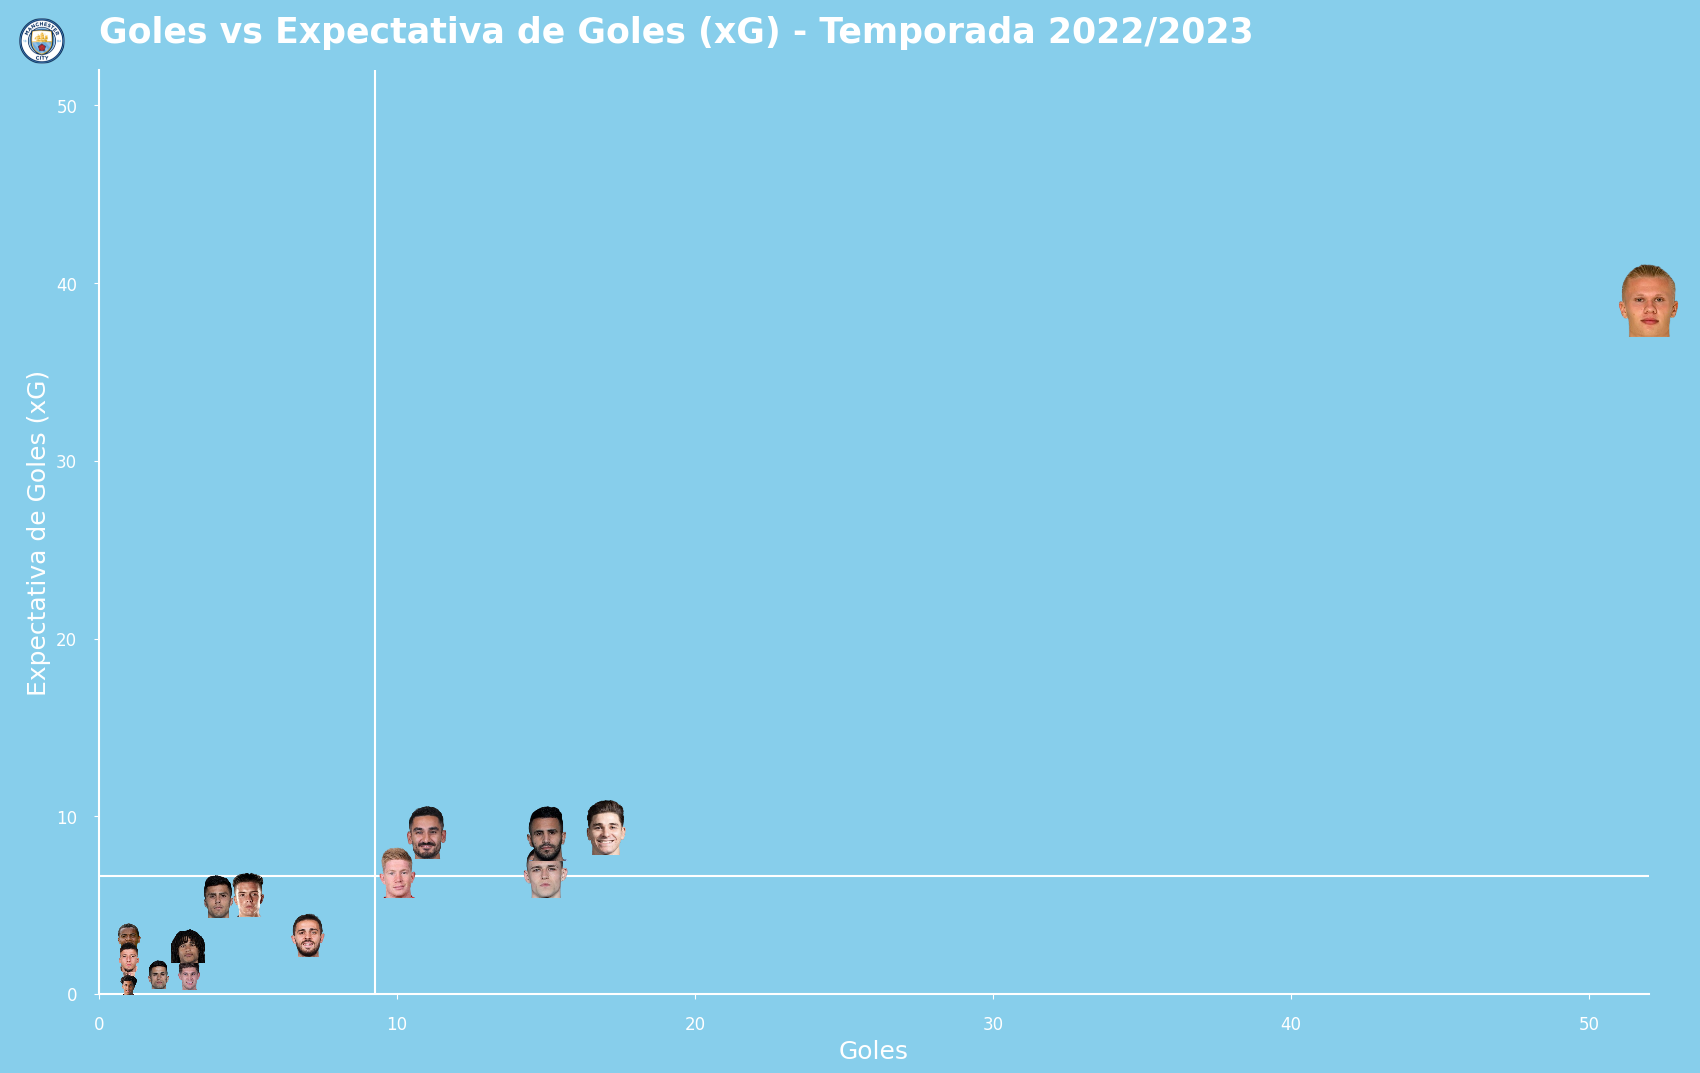

In [442]:
def encontrar_archivo_mas_parecido(jugador, files, threshold=0.6):
    posibles = difflib.get_close_matches(jugador, files, n=1, cutoff=threshold)
    return posibles[0] if posibles else None

# Obtener la lista de archivos en la carpeta 'players'
path = os.getcwd()
files = os.listdir('files')

# Filtrar los jugadores del DataFrame
jugadores_filtrados = df_plot["Jugador"].tolist()
files_filtrados = []

# Recorremos los jugadores y buscamos archivos similares
for jugador in jugadores_filtrados:
    jugador_normalizado = jugador.lower().replace(" ", "_")
    archivo_similar = encontrar_archivo_mas_parecido(jugador_normalizado, files)
    if archivo_similar:
        files_filtrados.append(archivo_similar)

# Ahora que ya tenemos la lista `files_filtrados`, puedes proceder a llamar a la función de ploteo
plot_stats(
    df=df_plot,
    stat_x="Rendimiento_Gls.",
    stat_y="Expectativa_xG",
    title="Temporada 2022/2023",
    xlabel="Goles",
    ylabel="Expectativa de Goles (xG)",
    files_filtrados=files_filtrados  # Lista de rutas de imágenes de jugadores
)

In [358]:
df_plot = df_stats[['Jugador','Rendimiento_Ass','Expectativa_xAG']]
df_plot = df_plot.iloc[:-2]
df_plot = df_plot[(df_plot['Rendimiento_Ass'] != 0) | (df_plot['Expectativa_xAG'] != 0)]
df_plot = df_plot.sort_values(by="Rendimiento_Ass",ascending=False)
df_plot = df_plot[:16]
df_plot = df_plot.sort_values(by="Jugador")
df_plot = df_plot.dropna()

df_plot

,Jugador,Rendimiento_Ass,Expectativa_xAG
6,Bernardo Silva,6.0,4.6
20,Cole Palmer,1.0,0.6
1,Ederson,1.0,0.2
2,Erling Haaland,9.0,6.1
7,Jack Grealish,11.0,10.0
12,John Stones,3.0,2.1
15,João Cancelo,5.0,1.9
14,Julián Álvarez,4.0,2.8
5,Kevin De Bruyne,28.0,17.2
11,Kyle Walker,1.0,0.4


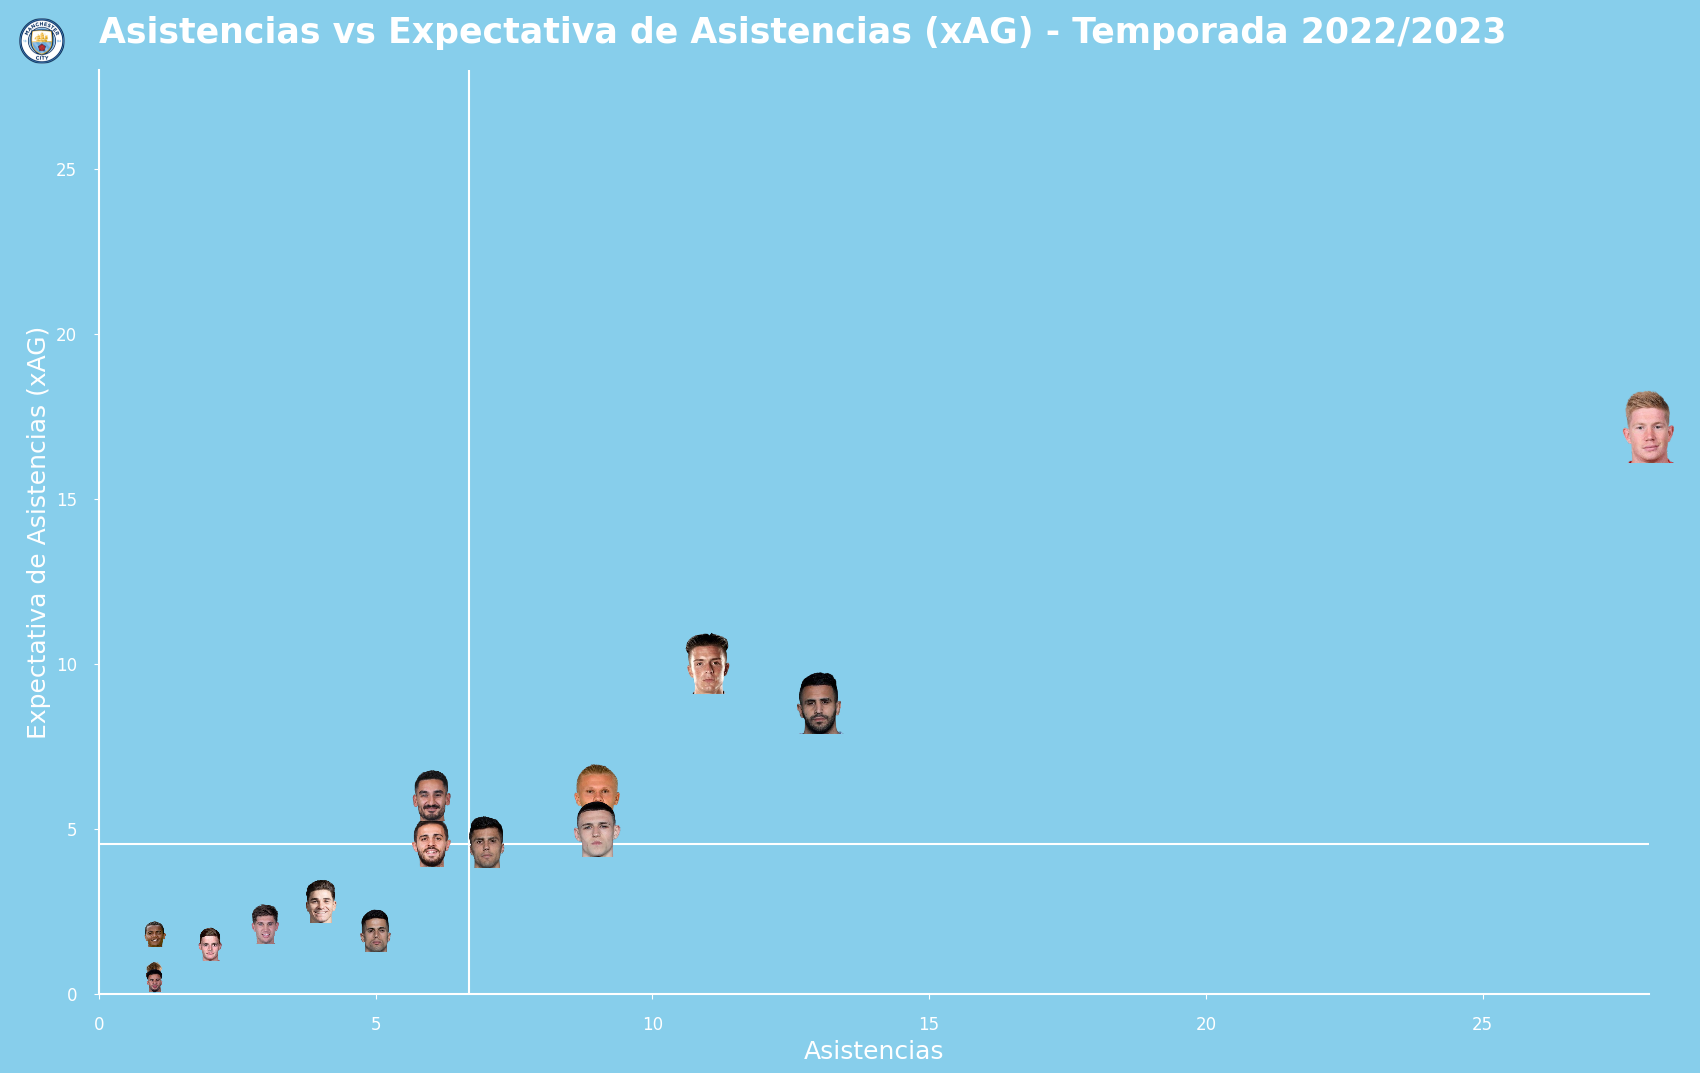

In [359]:
# Filtrar los jugadores del DataFrame
jugadores_filtrados = df_plot["Jugador"].tolist()
files_filtrados = []

# Recorremos los jugadores y buscamos archivos similares
for jugador in jugadores_filtrados:
    jugador_normalizado = jugador.lower().replace(" ", "_")
    archivo_similar = encontrar_archivo_mas_parecido(jugador_normalizado, files)
    if archivo_similar:
        files_filtrados.append(archivo_similar)

plot_stats(
    df=df_plot,
    stat_x="Rendimiento_Ass",
    stat_y="Expectativa_xAG",
    title="Temporada 2022/2023",
    xlabel="Asistencias",
    ylabel="Expectativa de Asistencias (xAG)",
    files_filtrados=files_filtrados  # Lista de rutas de imágenes de jugadores
)


In [360]:
from understatapi import UnderstatClient

with UnderstatClient() as understat:
    player_shot_data = understat.player(player="8260").get_shot_data()
    

In [361]:
df_haaland = pd.DataFrame(player_shot_data)
df_haaland = df_haaland[df_haaland["season"] == "2022"]
df_haaland.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
205,479846,20,MissedShots,0.9359999847412109,0.5029999923706054,0.48408499360084534,Erling Haaland,a,8260,OpenPlay,2022,Head,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,Phil Foden,Cross
206,479847,35,Goal,0.885,0.5,0.7611690163612366,Erling Haaland,a,8260,Penalty,2022,LeftFoot,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,None,Standard
207,479854,64,Goal,0.8640000152587891,0.405,0.32805299758911133,Erling Haaland,a,8260,OpenPlay,2022,LeftFoot,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,Kevin De Bruyne,Throughball
208,479855,69,MissedShots,0.9530000305175781,0.5520000076293945,0.5266079902648926,Erling Haaland,a,8260,OpenPlay,2022,Head,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,Jack Grealish,Chipped
209,479856,75,BlockedShot,0.894000015258789,0.71,0.06644280254840851,Erling Haaland,a,8260,OpenPlay,2022,LeftFoot,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,Ilkay Gündogan,Pass


In [362]:
df_haaland['X'] = pd.to_numeric(df_haaland['X']) * 100
df_haaland['Y'] = pd.to_numeric(df_haaland['Y']) * 100
df_haaland['xG'] = pd.to_numeric(df_haaland['xG'])

In [363]:
# Calculate the stats we'll need to display
# 1. Total shots
# 2. Total goals
# 3. Total xG
# 4. xG per shot
# 5. Average distance of shots

total_shots = df_haaland.shape[0]
total_goals = df_haaland[df_haaland['result'] == 'Goal'].shape[0]
total_xG = df_haaland['xG'].sum()
xG_per_shot = total_xG / total_shots
points_average_distance = df_haaland['X'].mean()
actual_average_distance = 110 - (df_haaland['X'] * 1.1).mean()
print(points_average_distance, actual_average_distance)

90.2333329983843 10.74333370177726


In [364]:
# Color -> They went with a black so we'll do the same. Notice how it isn't a pure black but rather a lighter little bit of grey black
background_color='skyblue'

In [365]:
pitch = VerticalPitch(
    pitch_type='opta', 
    half=True, 
    pitch_color=background_color, 
    pad_bottom=.5, 
    line_color='white',
    linewidth=.75,
    axis=True, label=True
)

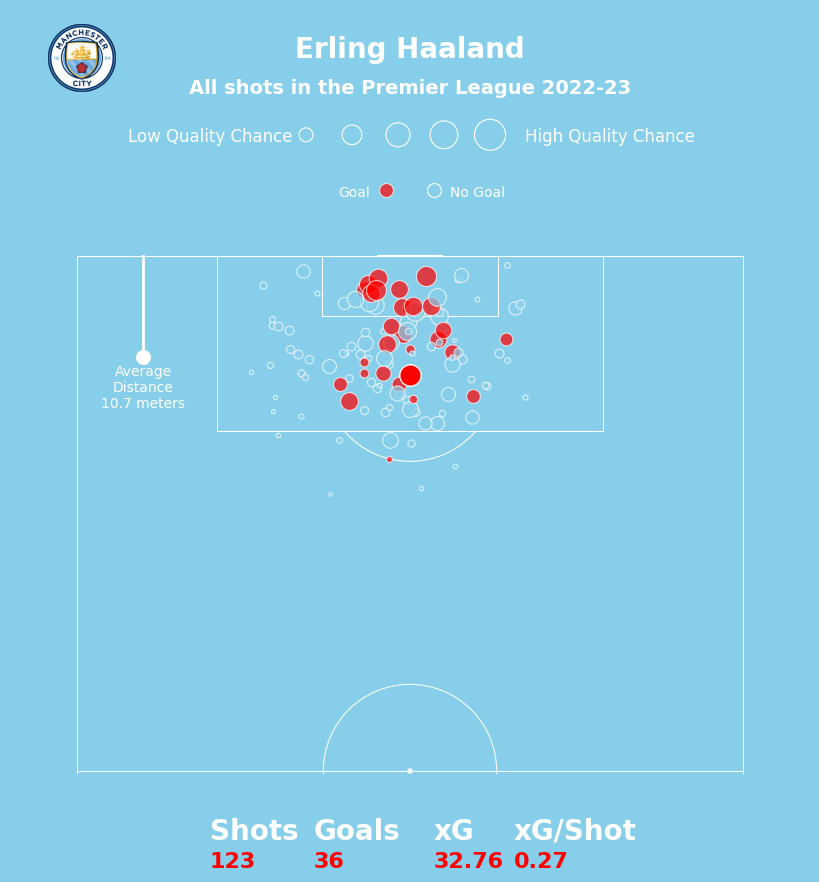

In [366]:
# create a subplot with 2 rows and 1 column
fig = plt.figure(figsize=(8, 12))
fig.patch.set_facecolor(background_color)


# Top row for the team names and score
# [left, bottom, width, height]

ax1 = fig.add_axes([0, 0.7, 1, .2])
ax1.set_facecolor(background_color)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)


ax1.text(
    x=0.5, 
    y=.85, 
    s='Erling Haaland', 
    fontsize=20, 
    fontweight='bold', 
    color='white', 
    ha='center'
)
ax1.text(
    x=0.5, 
    y=.7, 
    s=f'All shots in the Premier League 2022-23', 
    fontsize=14,
    fontweight='bold',
    color='white', 
    ha='center'
)
ax1.text(
    x=0.25, 
    y=0.5, 
    s=f'Low Quality Chance', 
    fontsize=12, 
    color='white', 
    ha='center'
)

# add a scatter point between the two texts
x_legend = np.linspace(start=0.37,stop=.6,num=5)
y_legend = np.asarray([.53]*5)
sizes = np.linspace(start=100,stop=500,num=5)

ax1.scatter(x=x_legend,
            y=y_legend,
            s=sizes,
            color=background_color, 
            edgecolor='white', 
            linewidth=.8)

ax1.text(
    x=0.75, 
    y=0.5, 
    s=f'High Quality Chance', 
    fontsize=12, 
    color='white', 
    ha='center'
)

ax1.scatter(
    x=0.47, 
    y=0.3, 
    s=100, 
    color='red', 
    edgecolor='white', 
    linewidth=.8,
    alpha=.7
)


ax1.text(
    x=0.45, 
    y=0.27, 
    s=f'Goal', 
    fontsize=10, 
    color='white', 
    ha='right'
)

ax1.scatter(
    x=0.53, 
    y=0.3, 
    s=100, 
    color=background_color, 
    edgecolor='white', 
    linewidth=.8
)

ax1.text(
    x=0.55, 
    y=0.27, 
    s=f'No Goal', 
    fontsize=10, 
    color='white', 
    ha='left'
)

ax1.set_axis_off()


ax2 = fig.add_axes([.05, 0.25, .9, .5])
ax2.set_facecolor(background_color)

pitch.draw(ax=ax2)


# create a scatter plot at y 100 - average_distance
ax2.scatter(
    x=90, 
    y=points_average_distance, 
    s=100, 
    color='white',  
    linewidth=.8
)
# create a line from the bottom of the pitch to the scatter point
ax2.plot(
    [90, 90], 
    [100, points_average_distance], 
    color='white', 
    linewidth=2
)

# Add a text label for the average distance
ax2.text(
    x=90, 
    y=points_average_distance - 5, 
    s=f'Average\nDistance\n{actual_average_distance:.1f} meters', 
    fontsize=10, 
    color='white', 
    ha='center'
)


for x in df_haaland.to_dict(orient='records'):
    pitch.scatter(
        x['X'], 
        x['Y'], 
        s=300 * x['xG'], 
        color='red' if x['result'] == 'Goal' else background_color, 
        ax=ax2,
        alpha=.7,
        linewidth=.8,
        edgecolor='white'
    )
    
ax2.set_axis_off()

# Configurar el tercer eje para las estadísticas
ax3 = fig.add_axes([0, .2, 1, .05])
ax3.set_facecolor(background_color)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

# Usar un bucle para agregar las estadísticas
stats = [
    {'label': 'Shots', 'value': total_shots, 'x': 0.25},
    {'label': 'Goals', 'value': total_goals, 'x': 0.38},
    {'label': 'xG', 'value': f'{total_xG:.2f}', 'x': 0.53},
    {'label': 'xG/Shot', 'value': f'{xG_per_shot:.2f}', 'x': 0.63}
]

for stat in stats:
    ax3.text(stat["x"], 0.5, s=stat["label"], fontsize=20, fontweight="bold", color = "white", ha = "left", va="center")
    ax3.text(stat["x"], 0, s=stat["value"], fontsize=16, fontweight="bold", color="red", ha="left", va="center")
    
ax3.set_axis_off()

ax_image = add_image(
        Image.open("files\manchestercity.png"), fig, left=0.03, bottom=0.83, height=0.08
        )

plt.show()

In [367]:
df_matches = pagina[6]
df_matches['Fecha'] = pd.to_datetime(df_matches['Fecha'], format='%Y-%m-%d')  # Asegúrate de usar el formato correcto

### 1. **Análisis de rendimiento en casa vs fuera**
   - **Descripción**: Compara el rendimiento del Manchester City cuando juega en casa vs cuando juega como visitante. Puedes analizar cómo varían las métricas de goles a favor (GF), goles en contra (GC), y xG dependiendo de la sede.
   - **Columnas relevantes**: `'Sedes'`, `'GF'`, `'GC'`, `'xG'`, `'xGA'`
   - **Visualización sugerida**: Gráficos de barras o gráficos de líneas para mostrar cómo varía el rendimiento en casa y fuera.
   
   **Ejemplo**:
   - ¿El Manchester City marca más goles o tiene un mejor xG en casa que fuera de casa?

In [368]:
partidos_casa = df_matches[df_matches['Sedes'] == 'Local']
partidos_fuera = df_matches[df_matches['Sedes'] == 'Visitante']

In [369]:
# Métricas en casa
promedio_casa_GF = partidos_casa['GF'].mean()
promedio_casa_GC = partidos_casa['GC'].mean()
promedio_casa_xG = partidos_casa['xG'].mean()
promedio_casa_xGA = partidos_casa['xGA'].mean()

# Métricas fuera
promedio_fuera_GF = partidos_fuera['GF'].mean()
promedio_fuera_GC = partidos_fuera['GC'].mean()
promedio_fuera_xG = partidos_fuera['xG'].mean()
promedio_fuera_xGA = partidos_fuera['xGA'].mean()

print(f"Promedio de GF en casa: {promedio_casa_GF}")
print(f"Promedio de GC en casa: {promedio_casa_GC}")
print(f"Promedio de xG en casa: {promedio_casa_xG}")
print(f"Promedio de xGA en casa: {promedio_casa_xGA}")
print()
print(f"Promedio de GF fuera: {promedio_fuera_GF}")
print(f"Promedio de GC fuera: {promedio_fuera_GC}")
print(f"Promedio de xG fuera: {promedio_fuera_xG}")
print(f"Promedio de xGA fuera: {promedio_fuera_xGA}")

Promedio de GF en casa: 3.3333333333333335
Promedio de GC en casa: 0.7
Promedio de xG en casa: 2.3480000000000003
Promedio de xGA en casa: 0.6560000000000001

Promedio de GF fuera: 1.6296296296296295
Promedio de GC fuera: 0.7777777777777778
Promedio de xG fuera: 1.8159999999999998
Promedio de xGA fuera: 0.9920000000000002


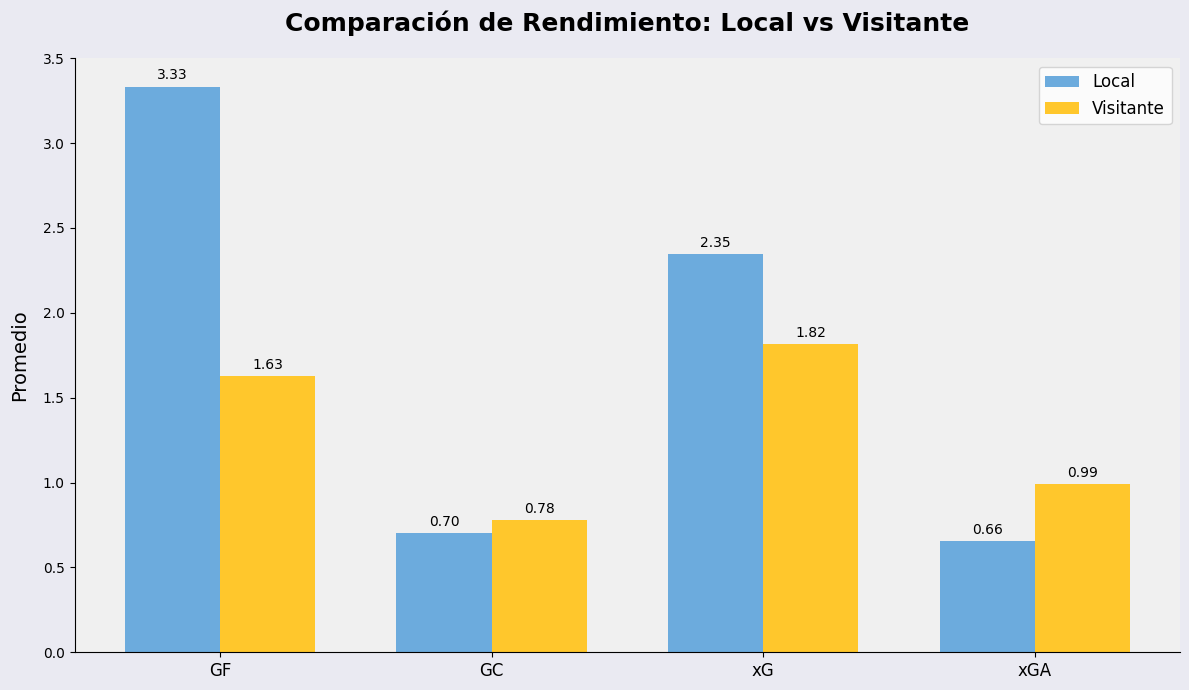

In [370]:
categorias = ['GF', 'GC', 'xG', 'xGA']
valores_casa = [promedio_casa_GF, promedio_casa_GC, promedio_casa_xG, promedio_casa_xGA]  # Ejemplo de valores para partidos en casa
valores_fuera = [promedio_fuera_GF, promedio_fuera_GC, promedio_fuera_xG, promedio_fuera_xGA]  # Ejemplo de valores para partidos fuera

# Configuración del gráfico
x = np.arange(len(categorias))  # etiquetas para las categorías
width = 0.35  # ancho de las barras

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, valores_casa, width, label='Local', color='#6CABDD')
rects2 = ax.bar(x + width/2, valores_fuera, width, label='Visitante', color='#FFC72C')

# Añadir etiquetas y título con formato mejorado
ax.set_ylabel('Promedio', fontsize=14, labelpad=10)
ax.set_title('Comparación de Rendimiento: Local vs Visitante', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(categorias, fontsize=12)
ax.legend(fontsize=12)

# Añadir etiquetas encima de las barras
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 puntos de desplazamiento
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Añadir fondo personalizado y estético
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('#eaeaf2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### 2. **Tendencias a lo largo de la temporada**
   - **Descripción**: Analiza las tendencias del rendimiento del equipo a lo largo de la temporada. Puedes observar cómo varían las métricas de goles, xG, y goles en contra conforme avanza la temporada.
   - **Columnas relevantes**: `'Fecha'`, `'GF'`, `'GC'`, `'xG'`, `'xGA'`
   - **Visualización sugerida**: Gráficos de líneas que muestren la evolución de las métricas clave durante la temporada.
   
   **Ejemplo**:
   - ¿Hubo algún periodo durante la temporada donde el rendimiento del equipo cayó o mejoró notablemente?

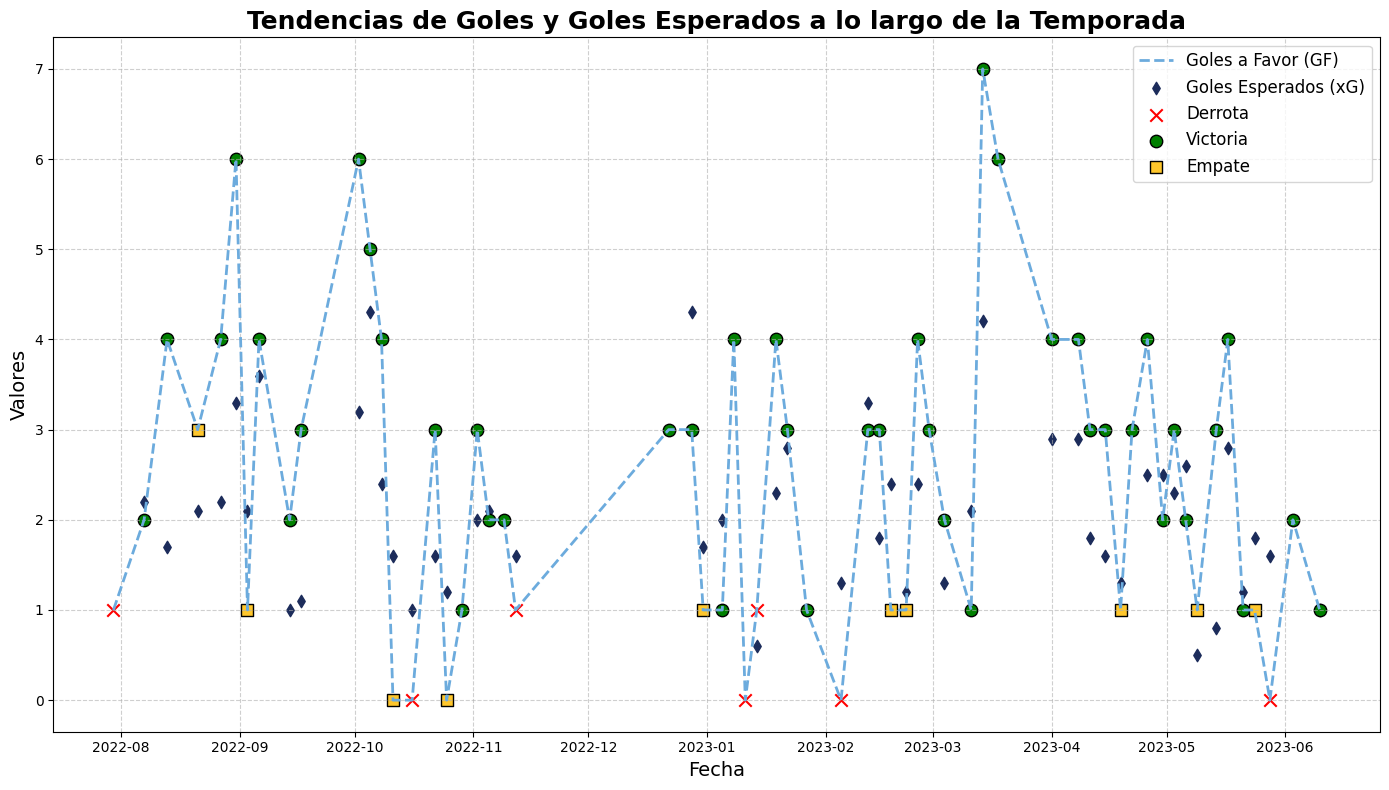

In [371]:
# Definir las métricas clave para observar las tendencias
fechas = df_matches['Fecha']
goles_favor = df_matches['GF']
goles_esperados = df_matches['xG']
resultados = df_matches['Resultado']

# Crear el gráfico combinado
plt.figure(figsize=(14, 8))

# Goles a Favor (GF) 
plt.plot(fechas, goles_favor, color='#6CABDD', linestyle='--', linewidth=2, label='Goles a Favor (GF)')

# Goles Esperados (xG)
plt.scatter(fechas, goles_esperados, color='#1C2C5B', label='Goles Esperados (xG)', marker='d', s=40)

# Identificar el resultado del partido y asignar un color o marcador específico
for fecha, gf, gc, resultado in zip(fechas, goles_favor, goles_esperados, resultados):
    if 'V' in resultado:  # Victoria
        plt.scatter(fecha, gf, color='green', marker='o', s=80, edgecolor='black', label='Victoria' if 'Victoria' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif 'E' in resultado:  # Empate
        plt.scatter(fecha, gf, color='#FFC72C', marker='s', s=80, edgecolor='black', label='Empate' if 'Empate' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:  # Derrota
        plt.scatter(fecha, gf, color='red', marker='x', s=80, edgecolor='black', label='Derrota' if 'Derrota' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title('Tendencias de Goles y Goles Esperados a lo largo de la Temporada', fontsize=18, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Valores', fontsize=14)

plt.legend(fontsize=12, loc='upper right')

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()


Con los datos de **jugadas defensivas**, hay varias ideas de análisis que se podrían realizar, enfocándose tanto en los jugadores individuales como en el rendimiento del equipo en general. 

### 3. **Rendimiento defensivo por posición**
   - **Descripción**: Analiza cómo varía el rendimiento defensivo según la posición del jugador en el campo (DF, CC, DL, etc.). Puedes comparar métricas clave como **derribos (Tkl)**, **bloqueos** e **intercepciones** para ver qué posiciones contribuyen más en defensa.
   - **Columnas clave**: `'Posc'`, `'Derribos_Tkl'`, `'Bloqueos_Bloqueos'`, `'Int'`, `'Tkl+Int'`
   - **Visualización sugerida**: Gráfico de barras apiladas o gráficos de radar para comparar el rendimiento por posición.

   **Ejemplo**:
   - ¿Qué posición realiza más intercepciones y bloqueos en el equipo?

In [372]:
df_defensivo = pagina[43]
df_defensivo.columns = ["_".join(col) if 'Unnamed' not in col[0] else col[1] for col in df_defensivo.columns.values]
df_defensivo.columns

Index(['Jugador', 'País', 'Posc', 'Edad', '90 s', 'Derribos_Tkl',
       'Derribos_TklG', 'Derribos_3.º def.', 'Derribos_3.º cent.',
       'Derribos_3.º ataq.', 'Desafíos_Tkl', 'Desafíos_Att', 'Desafíos_Tkl%',
       'Desafíos_Pérdida', 'Bloqueos_Bloqueos', 'Bloqueos_Dis',
       'Bloqueos_Pases', 'Int', 'Tkl+Int', 'Desp.', 'Err', 'Partidos'],
      dtype='object')

In [373]:
# Crear una nueva columna con solo la primera posición
df_defensivo['Posc'] = df_defensivo['Posc'].apply(lambda x: x.split(',')[0])

# Eliminar las posiciones combinadas, dejando solo la primera posición
df_posicion = df_defensivo.groupby('Posc').agg({
    'Derribos_TklG': 'sum',
    'Bloqueos_Bloqueos': 'sum',
    'Bloqueos_Dis': 'sum',
    'Bloqueos_Pases': 'sum',
    'Int': 'sum',
}).reset_index()

df_posicion

,Posc,Derribos_TklG,Bloqueos_Bloqueos,Bloqueos_Dis,Bloqueos_Pases,Int
0,CC,159,173,43,130,144
1,DF,211,150,59,91,181
2,DL,122,120,17,103,66
3,PO,1,0,0,0,2


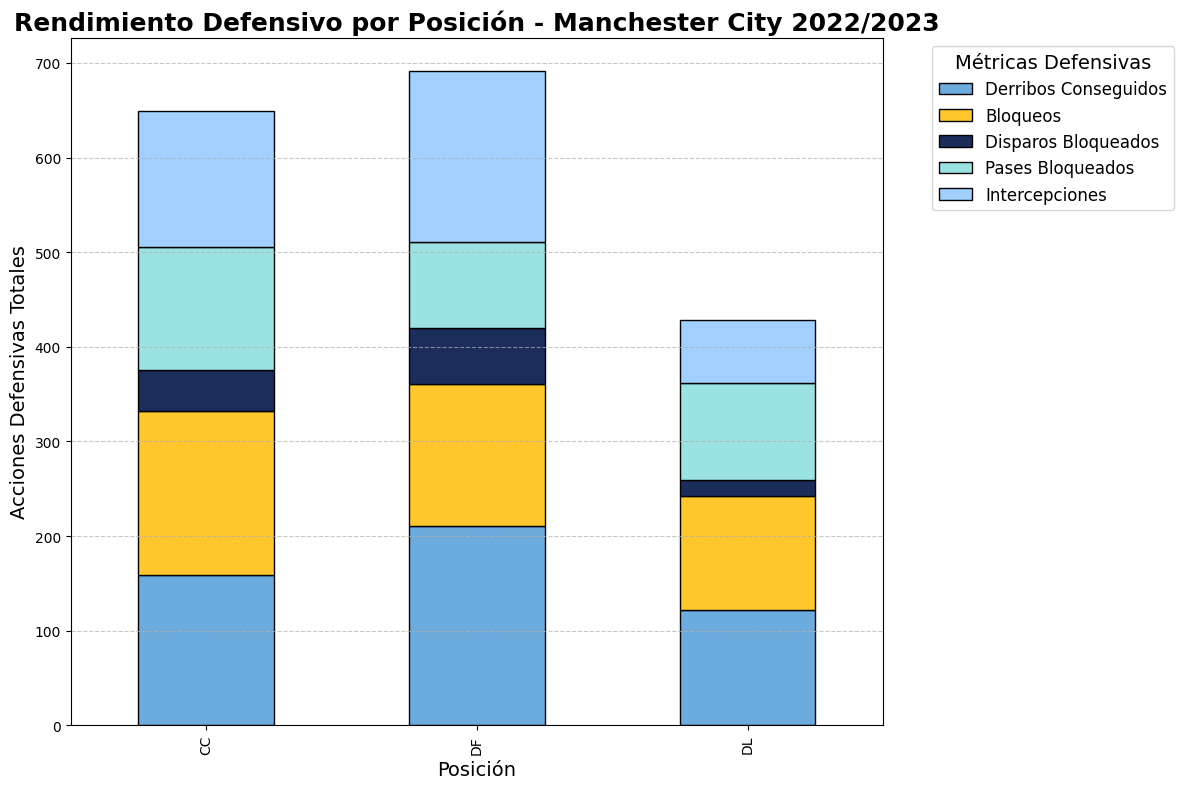

In [374]:
# Filtrar para eliminar los porteros (Posc = 'PO')
df_posicion_filtrado = df_posicion[df_posicion['Posc'] != 'PO']

# Usar colores pastel inspirados en los colores del Manchester City
colors = ['#6CABDD', '#FFC72C', '#1C2C5B', '#9BE3E2', '#A1D0FF']  # Azul claro, amarillo pastel, azul oscuro, cian claro, azul más claro

# Crear el gráfico de barras apiladas
ax = df_posicion_filtrado.set_index('Posc').plot(
    kind='bar', stacked=True, figsize=(12, 8), color=colors, edgecolor='black')

# Añadir títulos y etiquetas mejoradas
plt.title('Rendimiento Defensivo por Posición - Manchester City 2022/2023', fontsize=18, fontweight='bold')
plt.ylabel('Acciones Defensivas Totales', fontsize=14)
plt.xlabel('Posición', fontsize=14)

# Personalizar la leyenda con nombres más descriptivos
descriptive_labels = ['Derribos Conseguidos', 'Bloqueos', 'Disparos Bloqueados', 'Pases Bloqueados', 'Intercepciones']

# Actualizar la leyenda con las etiquetas descriptivas
ax.legend(descriptive_labels, title='Métricas Defensivas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Añadir cuadrícula solo en el eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### 4. **Comparación de jugadores clave en métricas defensivas**
   - **Descripción**: Compara a jugadores clave del Manchester City en las principales métricas defensivas como **derribos (Tkl)**, **bloqueos** y **despejes**. Puedes crear perfiles defensivos individuales para jugadores como **Rodri**, **Rúben Dias**, **Kyle Walker**, etc.
   - **Columnas clave**: `'Jugador'`, `'Derribos_Tkl'`, `'Bloqueos_Bloqueos'`, `'Desp.'`, `'Int'`, `'Err'`
   - **Visualización sugerida**: Gráficos de radar o gráficos de barras comparativos.

   **Ejemplo**:
   - ¿Cómo se compara Rodri con Rúben Dias en métricas defensivas como derribos y despejes?

In [375]:
# Filtrar los jugadores clave
jugadores_clave = ['Rodri', 'Rúben Dias', 'Kyle Walker', 'John Stones']
df_jugadores = df_defensivo[df_defensivo['Jugador'].isin(jugadores_clave)]

# Seleccionar las columnas clave
df_jugadores_comparacion = df_jugadores[['Jugador', 'Derribos_TklG', 'Bloqueos_Bloqueos', 'Desp.', 'Int', 'Err']]


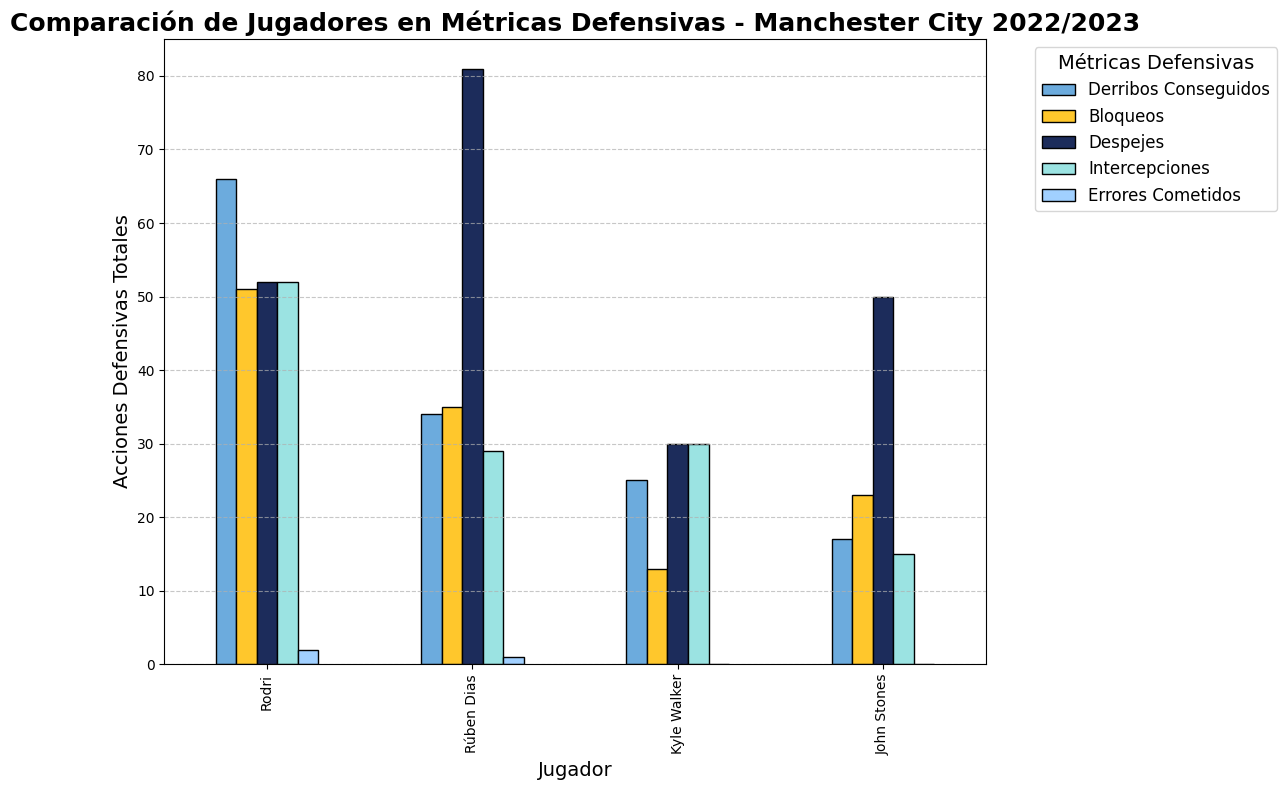

In [384]:
# Usar colores pastel inspirados en los colores del Manchester City
colors = ['#6CABDD', '#FFC72C', '#1C2C5B', '#9BE3E2', '#A1D0FF']  # Azul claro, amarillo pastel, azul oscuro, cian claro, azul más claro

# Crear un gráfico de barras para comparar los jugadores clave
ax = df_jugadores_comparacion.set_index('Jugador').plot(
    kind='bar', figsize=(12, 8), color=colors, edgecolor='black')

# Añadir títulos y etiquetas mejoradas
plt.title('Comparación de Jugadores en Métricas Defensivas - Manchester City 2022/2023', fontsize=18, fontweight='bold')
plt.ylabel('Acciones Defensivas Totales', fontsize=14)
plt.xlabel('Jugador', fontsize=14)

# Personalizar la leyenda con nombres más descriptivos
descriptive_labels = ['Derribos Conseguidos', 'Bloqueos', 'Despejes', 'Intercepciones', 'Errores Cometidos']
ax.legend(descriptive_labels, title='Métricas Defensivas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Añadir cuadrícula solo en el eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()



### 5. **Análisis de efectividad en los desafíos (Tkl%)**
   - **Descripción**: Analiza la efectividad de los jugadores en los desafíos defensivos. Puedes calcular el porcentaje de desafíos ganados (Tkl%) para diferentes jugadores y ver qué jugador tiene mayor éxito en sus intentos de derribo.
   - **Columnas clave**: `'Jugador'`, `'Desafíos_Tkl%'`, `'Desafíos_Att'`
   - **Visualización sugerida**: Gráficos de dispersión o gráficos de barras para comparar la efectividad de cada jugador.

   **Ejemplo**:
   - ¿Qué jugadores tienen la mayor efectividad en los desafíos defensivos? ¿Cómo se distribuyen sus intentos y éxitos?

In [398]:
# Seleccionar las columnas clave
df_efectividad = df_defensivo[['Jugador', 'Desafíos_Tkl%', 'Desafíos_Att']]

# Eliminar filas con valores nulos si es necesario
df_efectividad = df_efectividad[:-3]
df_efectividad = df_efectividad.dropna()

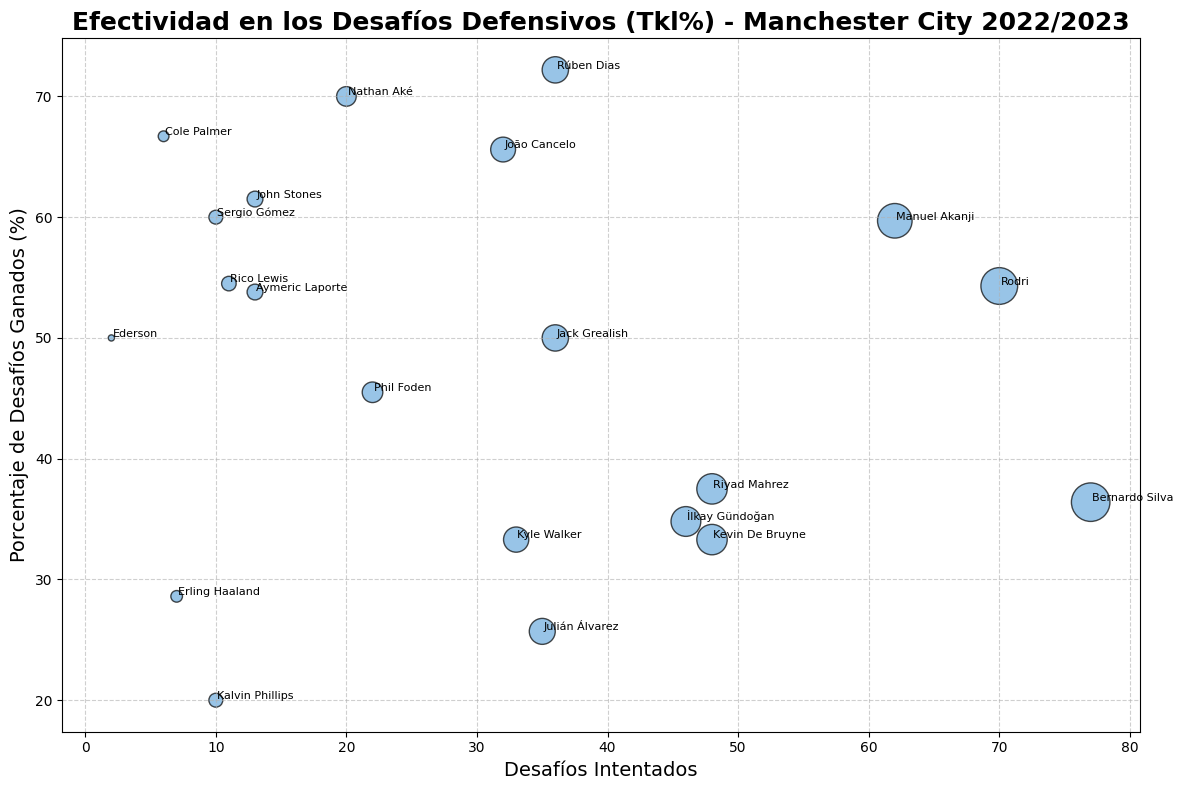

In [400]:
# Colores inspirados en el Manchester City
color_manchester = '#6CABDD'

# Crear un gráfico de dispersión con etiquetas
plt.figure(figsize=(12, 8))

# Tamaño de los puntos basado en los intentos de desafíos
sizes = df_efectividad['Desafíos_Att'] * 10  # Escalamos el tamaño de los puntos

# Gráfico de dispersión con color y tamaños personalizados
plt.scatter(df_efectividad['Desafíos_Att'], df_efectividad['Desafíos_Tkl%'], color=color_manchester, s=sizes, alpha=0.7, edgecolor='black')

# Añadir etiquetas a cada punto (jugador)
for i, jugador in enumerate(df_efectividad['Jugador']):
    plt.text(df_efectividad['Desafíos_Att'].iloc[i] + 0.1, df_efectividad['Desafíos_Tkl%'].iloc[i] + 0.1, jugador, fontsize=8)

# Título y etiquetas mejoradas
plt.title('Efectividad en los Desafíos Defensivos (Tkl%) - Manchester City 2022/2023', fontsize=18, fontweight='bold')
plt.xlabel('Desafíos Intentados', fontsize=14)
plt.ylabel('Porcentaje de Desafíos Ganados (%)', fontsize=14)

# Añadir cuadrícula más suave
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar el layout para que las etiquetas no se corten
plt.tight_layout()

# Mostrar el gráfico
plt.show()



### 6. **Contribución defensiva por tiempo jugado (por 90 minutos)**
   - **Descripción**: Normaliza las estadísticas defensivas por 90 minutos jugados para comparar mejor a los jugadores que no han jugado la misma cantidad de minutos. Esto puede ayudar a identificar jugadores que son efectivos defensivamente pero han jugado menos partidos.
   - **Columnas clave**: `'Jugador'`, `'90 s'`, `'Derribos_Tkl'`, `'Bloqueos_Bloqueos'`, `'Int'`
   - **Visualización sugerida**: Gráficos de barras comparando las métricas por 90 minutos jugados.

   **Ejemplo**:
   - ¿Quién es el jugador más eficiente en intercepciones o bloqueos por 90 minutos jugados?

In [427]:
# Normalizar métricas por 90 minutos jugados
df_normalizado = df_defensivo.copy()
df_normalizado['Derribos_por90'] = df_defensivo['Derribos_Tkl'] / df_defensivo['90 s']
df_normalizado['Bloqueos_por90'] = df_defensivo['Bloqueos_Bloqueos'] / df_defensivo['90 s']
df_normalizado['Int_por90'] = df_defensivo['Int'] / df_defensivo['90 s']
df_normalizado = df_normalizado[:-3]

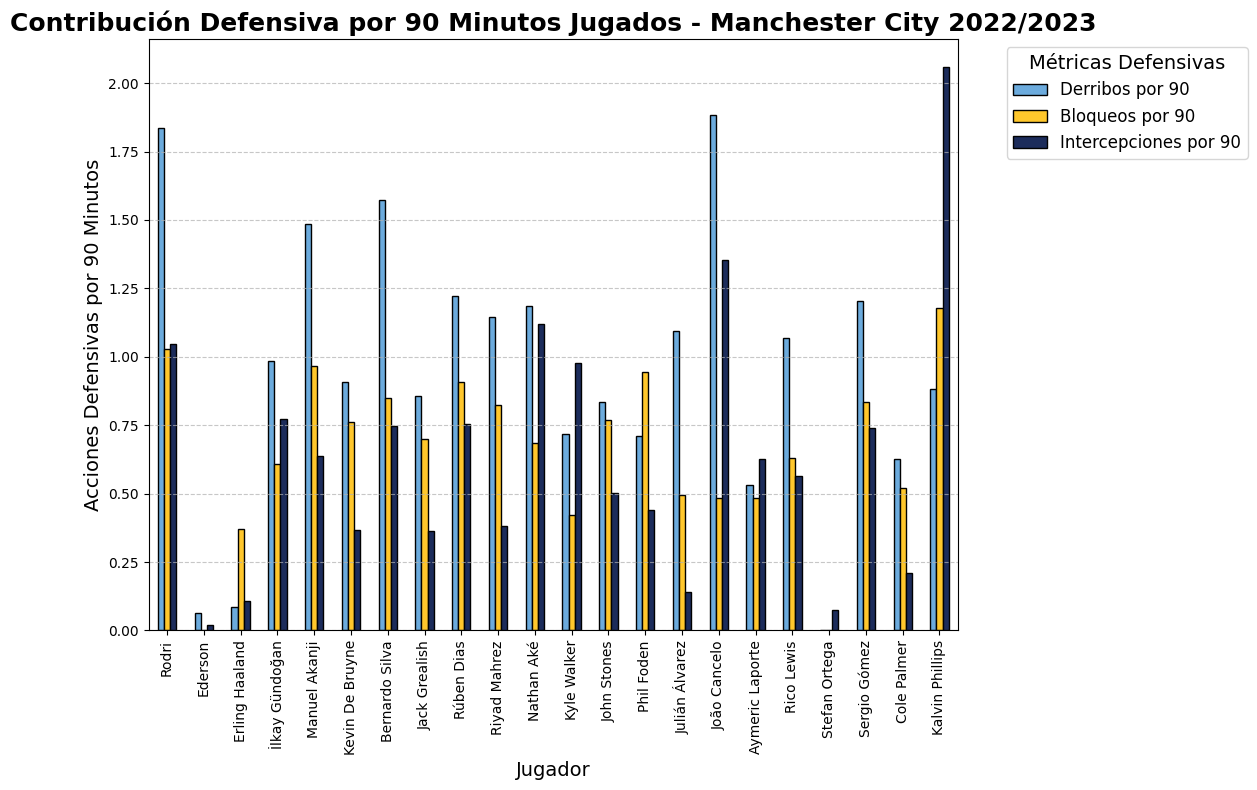

In [417]:
# Usar colores pastel inspirados en los colores del Manchester City
colors = ['#6CABDD', '#FFC72C', '#1C2C5B']  # Azul claro, amarillo pastel, azul oscuro

# Crear un gráfico de barras comparando las contribuciones por 90 minutos jugados
ax = df_normalizado[['Jugador', 'Derribos_por90', 'Bloqueos_por90', 'Int_por90']].set_index('Jugador').plot(
    kind='bar', figsize=(12, 8), color=colors, edgecolor='black')

# Añadir títulos y etiquetas mejoradas
plt.title('Contribución Defensiva por 90 Minutos Jugados - Manchester City 2022/2023', fontsize=18, fontweight='bold')
plt.ylabel('Acciones Defensivas por 90 Minutos', fontsize=14)
plt.xlabel('Jugador', fontsize=14)

# Personalizar la leyenda con nombres más descriptivos
descriptive_labels = ['Derribos por 90', 'Bloqueos por 90', 'Intercepciones por 90']
ax.legend(descriptive_labels, title='Métricas Defensivas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Añadir cuadrícula solo en el eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout para que las etiquetas no se corten
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### 7. **Desempeño defensivo en terceras partes del campo**
   - **Descripción**: Analiza cómo se distribuyen las acciones defensivas en las diferentes zonas del campo (tercio defensivo, centro, ataque). Esto puede mostrar dónde los jugadores realizan más intervenciones y cómo el equipo defiende en diferentes áreas.
   - **Columnas clave**: `'Derribos_3.º def.'`, `'Derribos_3.º cent.'`, `'Derribos_3.º ataq.'`
   - **Visualización sugerida**: Gráficos de calor para representar dónde suceden más intervenciones defensivas, o gráficos de barras comparando las zonas.

   **Ejemplo**:
   - ¿Dónde ocurre la mayor parte de las intervenciones defensivas: en el tercio defensivo, central o atacante?

In [425]:
# Agrupar por posición y sumar las métricas defensivas por zona del campo
df_zonas = df_defensivo.groupby('Posc').agg({
    'Derribos_3.º def.': 'sum',
    'Derribos_3.º cent.': 'sum',
    'Derribos_3.º ataq.': 'sum'
}).reset_index()

df_zonas = df_zonas[df_zonas['Posc'] != 'PO']

# Visualizar los datos agrupados
df_zonas

,Posc,Derribos_3.º def.,Derribos_3.º cent.,Derribos_3.º ataq.
0,CC,84,92,52
1,DF,125,104,26
2,DL,41,82,47


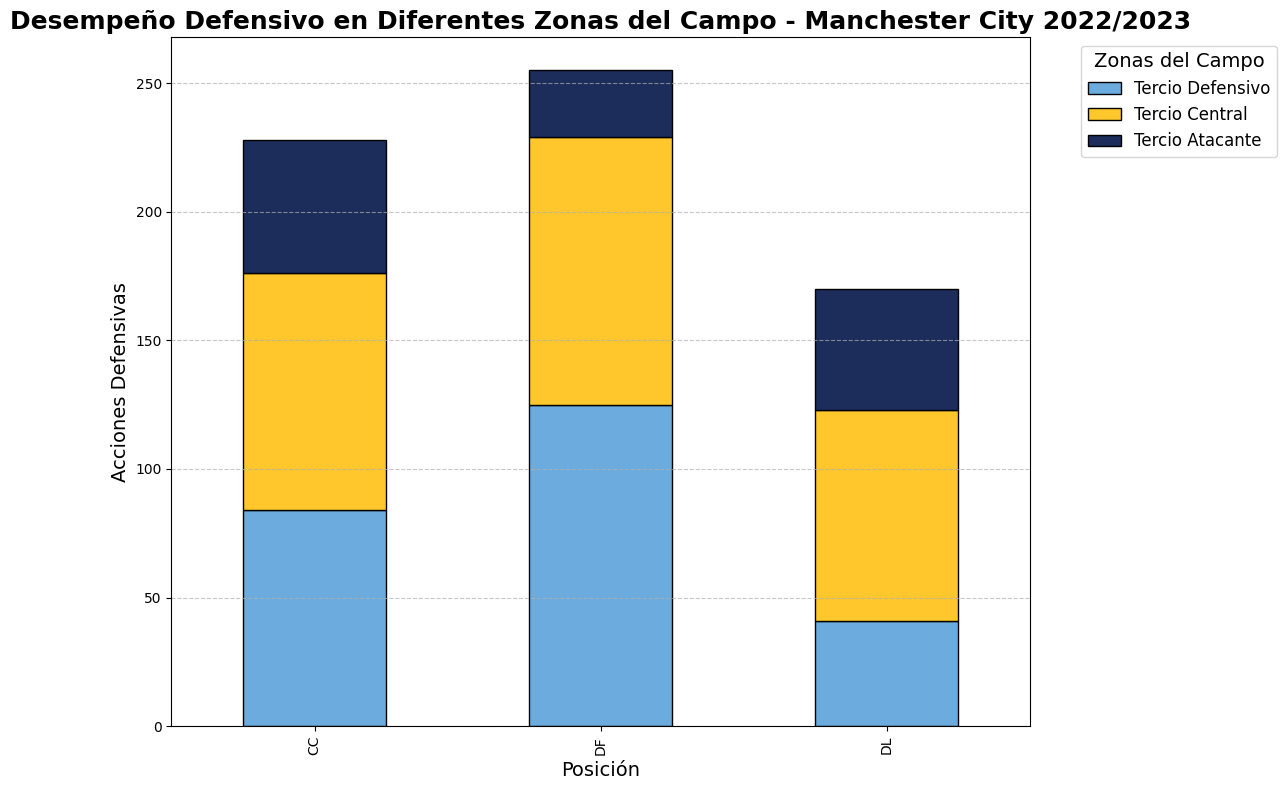

In [424]:
# Usar colores pastel inspirados en los colores del Manchester City
colors = ['#6CABDD', '#FFC72C', '#1C2C5B']  # Azul claro, amarillo pastel, azul oscuro

# Crear el gráfico de barras apiladas
ax = df_zonas.set_index('Posc').plot(kind='bar', stacked=True, figsize=(12, 8), color=colors, edgecolor='black')

# Añadir títulos y etiquetas mejoradas
plt.title('Desempeño Defensivo en Diferentes Zonas del Campo - Manchester City 2022/2023', fontsize=18, fontweight='bold')
plt.ylabel('Acciones Defensivas', fontsize=14)
plt.xlabel('Posición', fontsize=14)

# Personalizar la leyenda con nombres más descriptivos
descriptive_labels = ['Tercio Defensivo', 'Tercio Central', 'Tercio Atacante']
ax.legend(descriptive_labels, title='Zonas del Campo', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Añadir cuadrícula solo en el eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout para que las etiquetas no se corten
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### 8. **Errores y pérdidas de balón (análisis de riesgo defensivo)**
   - **Descripción**: Analiza el número de errores cometidos y las pérdidas de balón por parte de los jugadores defensivos. Esto puede ayudar a identificar jugadores que toman riesgos o cometen más errores en defensa.
   - **Columnas clave**: `'Jugador'`, `'Err'`, `'Desafíos_Pérdida'`
   - **Visualización sugerida**: Gráficos de dispersión o gráficos de barras.

   **Ejemplo**:
   - ¿Qué jugadores son más propensos a cometer errores o perder desafíos defensivos?

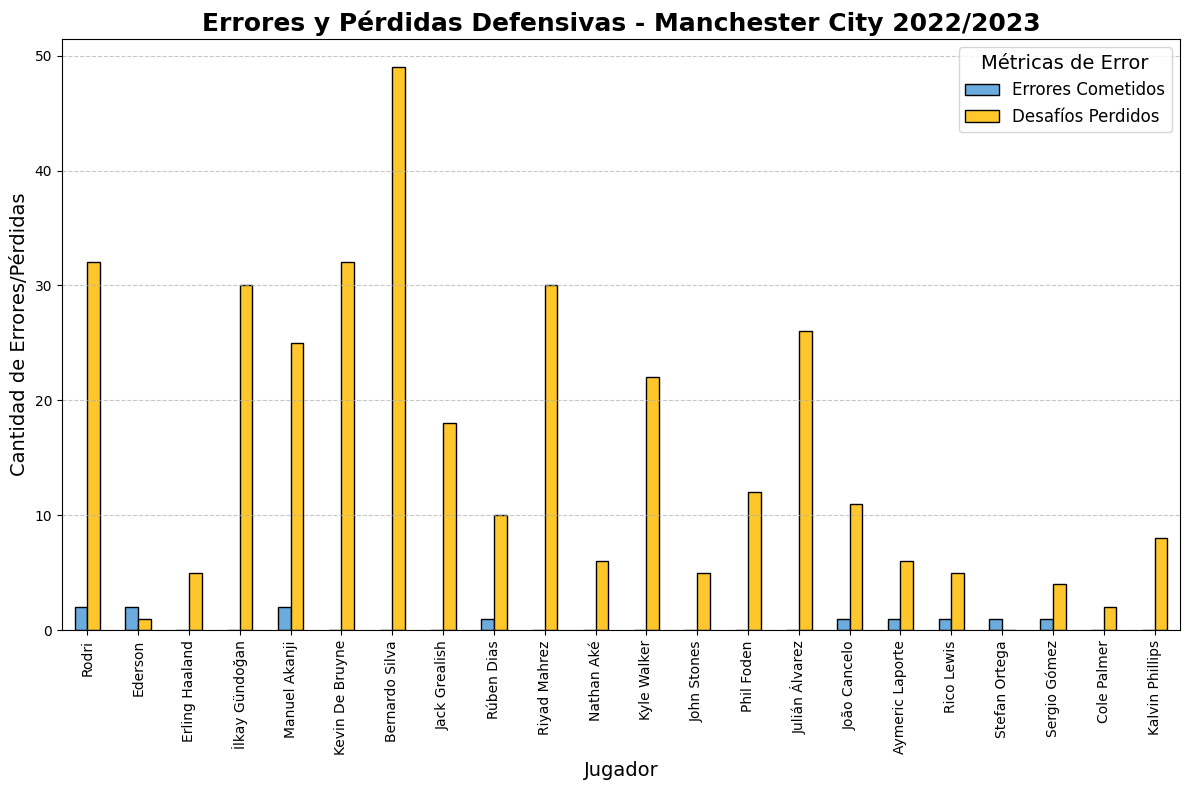

In [432]:
# Filtrar y seleccionar los errores y pérdidas
df_errores = df_defensivo[['Jugador', 'Err', 'Desafíos_Pérdida']]
df_errores = df_errores[:-3]

# Usar colores pastel inspirados en los colores del Manchester City
colors = ['#6CABDD', '#FFC72C']  # Azul claro y amarillo pastel

# Crear un gráfico de barras para los errores y pérdidas
ax = df_errores.set_index('Jugador').plot(kind='bar', figsize=(12, 8), color=colors, edgecolor='black')

# Añadir títulos y etiquetas mejoradas
plt.title('Errores y Pérdidas Defensivas - Manchester City 2022/2023', fontsize=18, fontweight='bold')
plt.ylabel('Cantidad de Errores/Pérdidas', fontsize=14)
plt.xlabel('Jugador', fontsize=14)

# Personalizar la leyenda con nombres más descriptivos
descriptive_labels = ['Errores Cometidos', 'Desafíos Perdidos']
ax.legend(descriptive_labels, title='Métricas de Error', loc='upper right', fontsize=12, title_fontsize=14)

# Añadir cuadrícula solo en el eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout para que las etiquetas no se corten
plt.tight_layout()

# Mostrar el gráfico
plt.show()